In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


Importing libraries for plotting and pca

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Let's read all the csv files

In [3]:
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [4]:
print('Train shape:',train_features.shape)
print('Test shape:',test_features.shape)

Train shape: (23814, 876)
Test shape: (3982, 876)


In [5]:
# check for missing values in train and test data
print(train_features.isnull().sum().value_counts())
print(test_features.isnull().sum().value_counts())

0    876
dtype: int64
0    876
dtype: int64


Great! no missing values.
Let us take a look at the features of train and test data.

In [6]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [7]:
test_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [8]:
train_features['train/test'] = 'train'
test_features['train/test'] = 'test '

In [9]:
# combining train and test features for the purpose of data exploaration
train_test_concat = pd.concat([train_features, test_features])
train_test_concat

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,train/test
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [10]:
# helper function to plot countplots for categorical features
def plotc(x, title):
    sns.set_style('darkgrid')
    sns.catplot(x = x, hue = 'train/test', kind = 'count', data = train_test_concat, palette = 'pastel');
    plt.title('Countplot for '+ title);

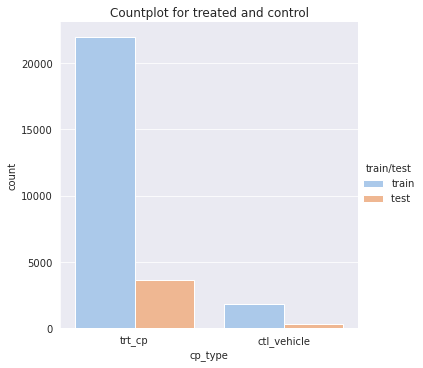

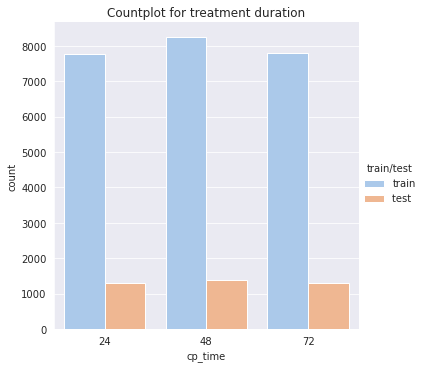

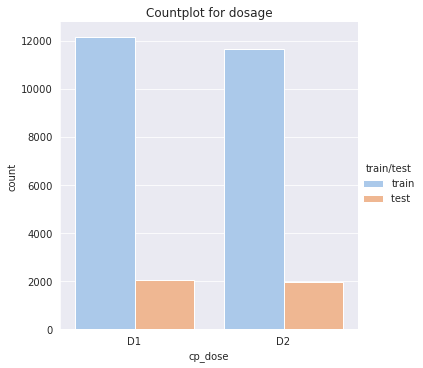

In [11]:
# Plotting count plots for cp_type, cp_time and cp_dose
plotc('cp_type', 'treated and control')
plotc('cp_time', 'treatment duration')
plotc('cp_dose', 'dosage')

* There are very few control observations and these control observaions have no MoA.
* The distribution of treatment durations is almost equal for all 3 categories(24hr, 48hr, 72hr) in both train and test data.
* The distribution of dosage is equal for D1 & D2 in both train and test data.

In [12]:
# separating the gene expression columns (g-) and cell viability columns (c-)
gene_columns = [col for col in train_features.columns if col.startswith('g-')]
cell_columns = [col for col in train_features.columns if col.startswith('c-')]

In [13]:
print("Gene expression columns:", len(gene_columns), "\nCell viability columns:", len(cell_columns))

Gene expression columns: 772 
Cell viability columns: 100


In [14]:
# helper function for plotting distribution of gen expression and cell viability data
def plotd(col, label, color):
    sns.set_style('darkgrid')
    sns.distplot(train_features[col], kde = True, color = color, label = label);

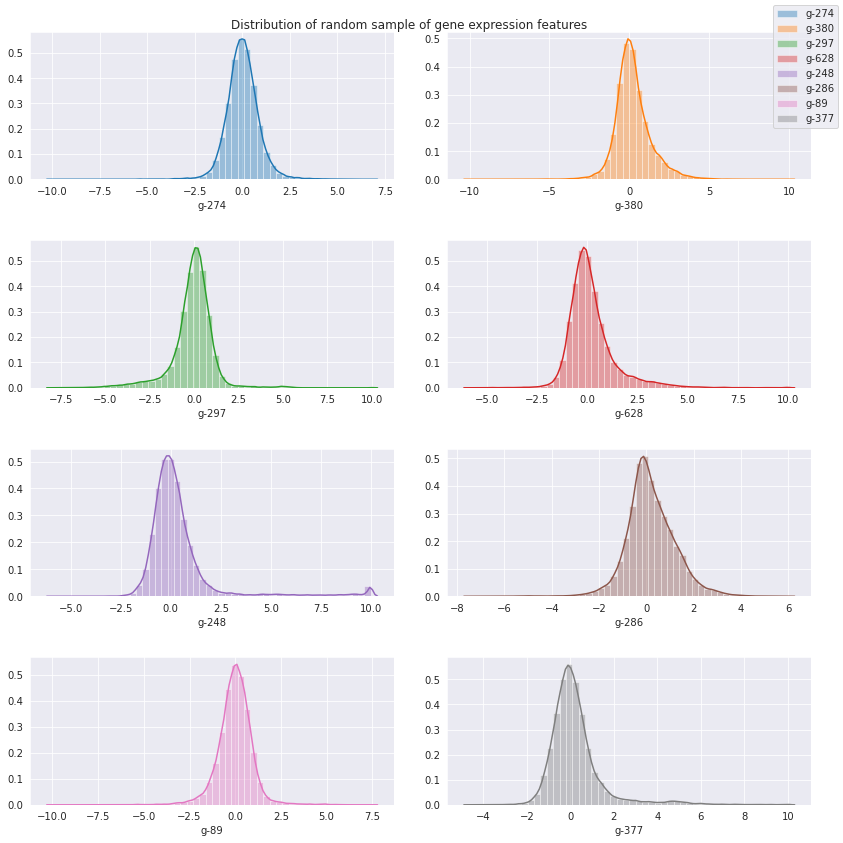

In [15]:
# Plotting distribution of randomly selected gene expression features
fig = plt.figure(figsize = (12,12))
plt.suptitle('Distribution of random sample of gene expression features')
cols = random.sample(gene_columns, 8)
colors = plt.rcParams["axes.prop_cycle"]()
for i in range(len(cols)):
    c = next(colors)["color"]
    plt.subplot(4,2,i+1)
    plotd(cols[i], label = cols[i], color=c)
fig.tight_layout(pad = 3.0)
fig.legend(loc="upper right")
plt.show()

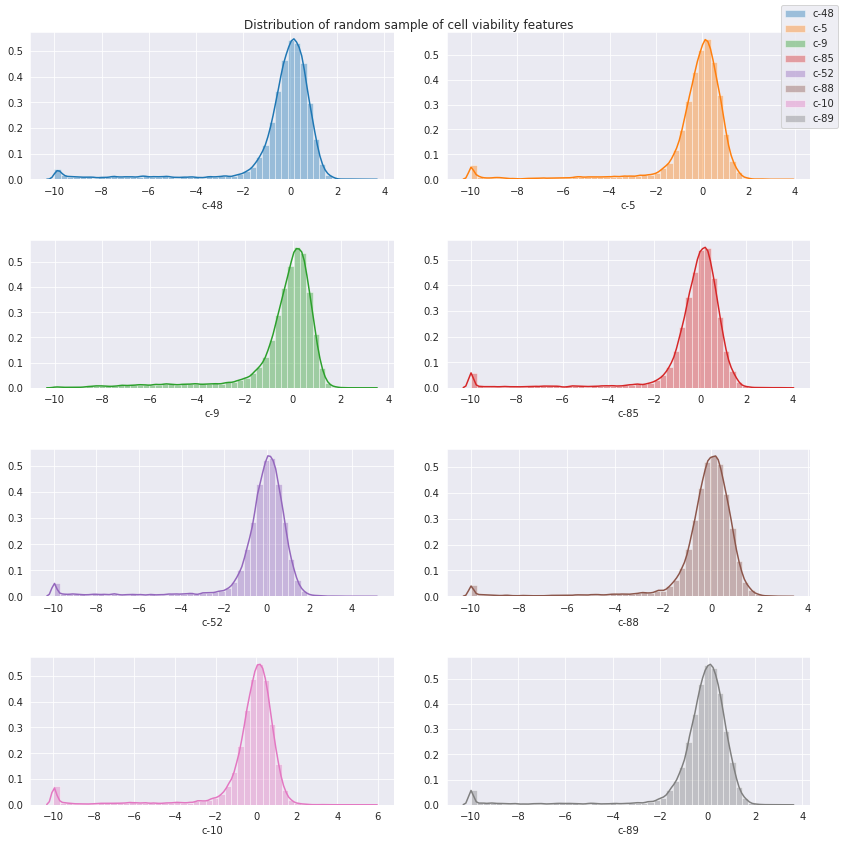

In [16]:
# Plotting distribution of randomly selected cell viability features
fig = plt.figure(figsize = (12,12))
plt.suptitle('Distribution of random sample of cell viability features')
cols = random.sample(cell_columns, 8)
colors = plt.rcParams["axes.prop_cycle"]()
for i in range(len(cols)):
    c = next(colors)["color"]
    plt.subplot(4,2,i+1)
    plotd(cols[i],label = cols[i], color=c)
fig.tight_layout(pad = 3.0)
fig.legend(loc="upper right")
plt.show()

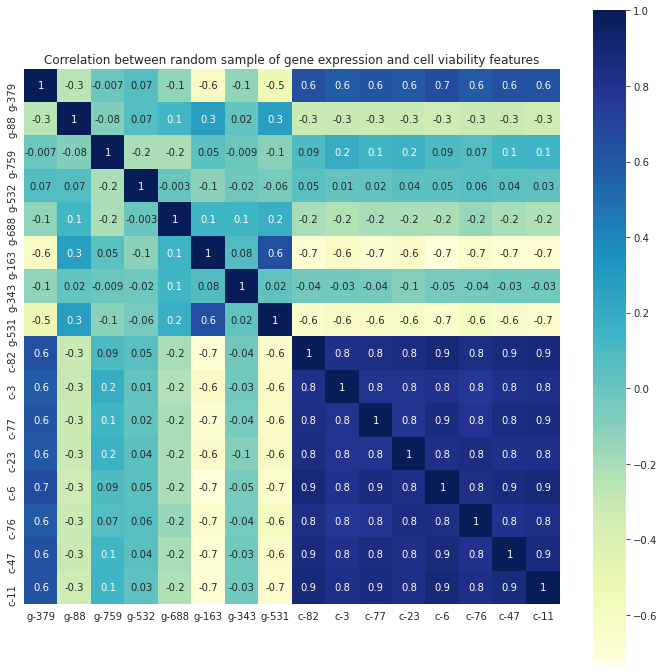

In [17]:
# plotting correlation matrix for randomly selected features
selected_cols = random.sample(gene_columns, 8) + random.sample(cell_columns, 8)
corr_selected_cols = train_features[selected_cols].corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr_selected_cols, cmap="YlGnBu", annot = True, fmt = '.1g', square = True)
plt.title('Correlation between random sample of gene expression and cell viability features');

In [18]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# getting the column wise sum of all targets (number of positive responses for each target)
x = train_targets_scored.drop('sig_id', axis = 1).sum().sort_values().reset_index()
x.columns = ['target','num_pos_responses']
x

,target,num_pos_responses
0,atp-sensitive_potassium_channel_antagonist,1
1,erbb2_inhibitor,1
2,diuretic,6
3,autotaxin_inhibitor,6
4,protein_phosphatase_inhibitor,6
...,...,...
201,serotonin_receptor_antagonist,404
202,dopamine_receptor_antagonist,424
203,cyclooxygenase_inhibitor,435
204,proteasome_inhibitor,726


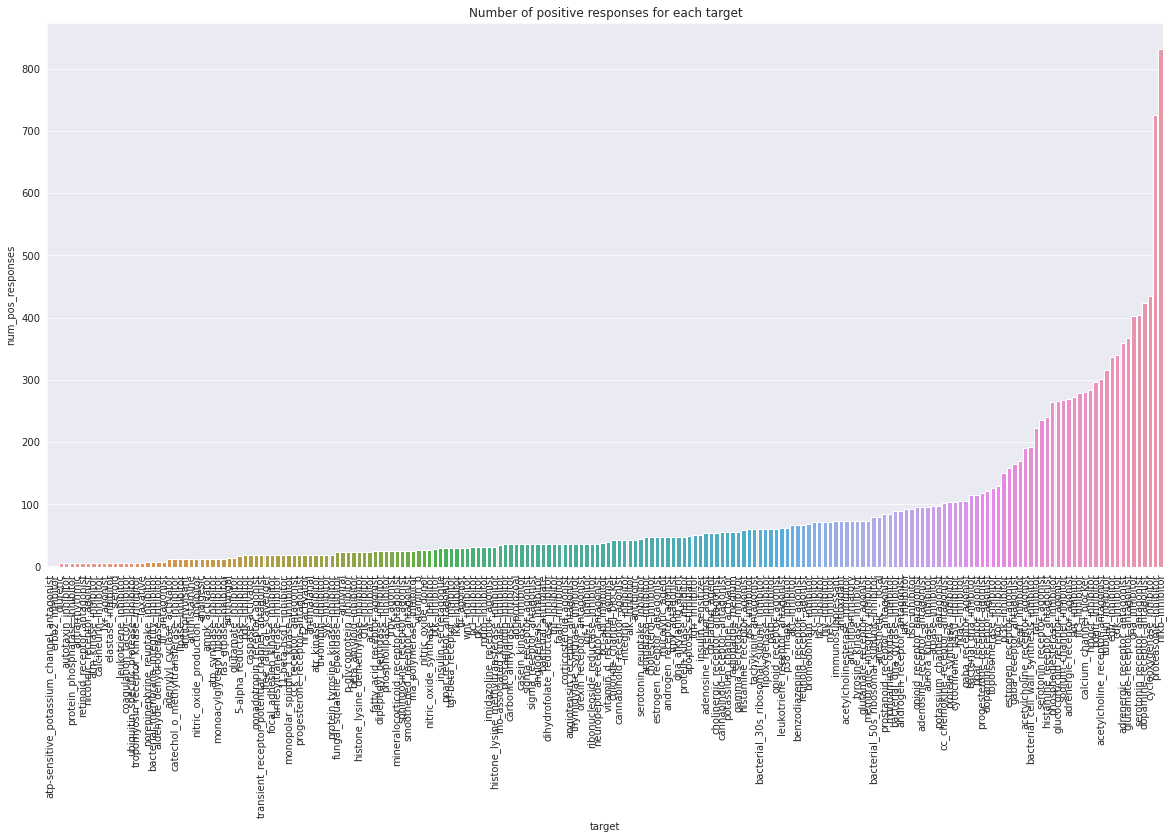

In [20]:
# plotting the number of positive responses for each target class
fig = plt.figure(figsize = (20,10))
plt.title('Number of positive responses for each target')
ax = sns.barplot(x = 'target', y = 'num_pos_responses', data = x)
ax.set_xticklabels(x.target, rotation = 90);

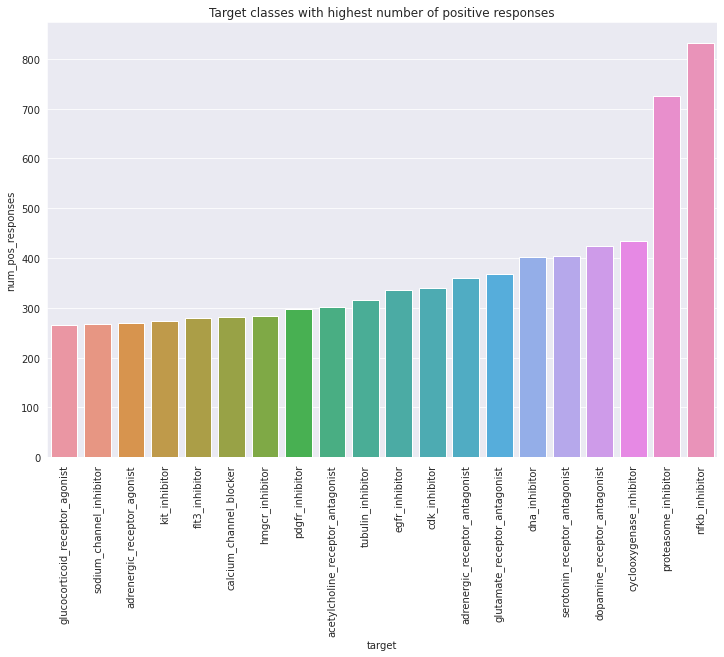

In [21]:
# plotting the target classes with highest number of positive responses
fig = plt.figure(figsize = (12,8))
plt.title('Target classes with highest number of positive responses')
ax = sns.barplot(x = 'target', y = 'num_pos_responses', data = x.tail(20))
ax.set_xticklabels(x.tail(20).target, rotation = 90);

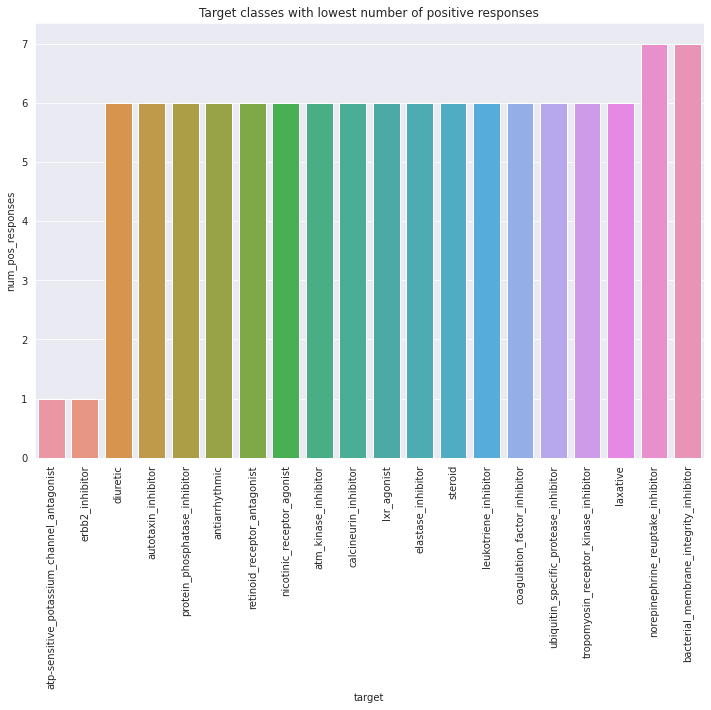

In [22]:
# plotting the target classes with lowest number of positive responses
fig = plt.figure(figsize = (12,8))
plt.title('Target classes with lowest number of positive responses')
ax = sns.barplot(x = 'target', y = 'num_pos_responses', data = x.head(20))
ax.set_xticklabels(x.head(20).target, rotation = 90);

In [23]:
# getting the row wise sum of all the unique sig_id (number of activations per sig_id)
y = train_targets_scored.sum(axis = 1)
# number of observations for each number of activations
y.value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

* Majority of the sig_ids have 1 activation and a considerable number of observations have no activations
* The number of observations decreases for higher number of activations .

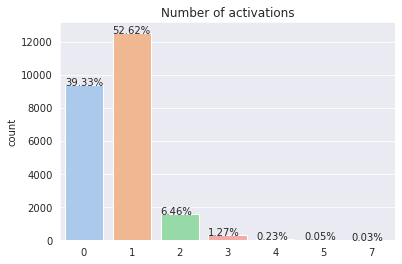

In [24]:
ax = sns.countplot(y, palette = 'pastel')
plt.title('Number of activations');
total = len(y)
for p in ax.patches:
    ht = p.get_height()
    ax.text(p.get_x(), ht, '{:1.2f}%'.format(ht*100/total))

In [25]:
new_train_features = train_features.copy()
new_train_features.drop(columns = ['sig_id','cp_type','cp_time','cp_dose','train/test'], inplace = True)
new_train_features

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,-0.0340,0.4865,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,0.4299,-0.7985,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [26]:
scaler = StandardScaler()
scaler.fit(new_train_features)

StandardScaler()

In [27]:
train_transform = scaler.transform(new_train_features)
(np.min(train_transform), np.max(train_transform))

(-16.39216750694353, 17.24206077021441)

In [28]:
print('new_train_features', new_train_features.shape)
print('train_transform', train_transform.shape)

new_train_features (23814, 872)
train_transform (23814, 872)


In [29]:
pca = PCA().fit(train_transform)

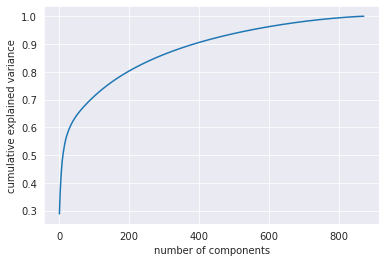

In [30]:
# plotting the explained variance
sns.set_style('darkgrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

* Around 400 components to explain 90% of the variance
* Around 800 components to explain almost 100% of the variance

References: 
* https://www.kaggle.com/headsortails/explorations-of-action-moa-eda
* https://www.kaggle.com/isaienkov/mechanisms-of-action-moa-prediction-eda